<a href="https://colab.research.google.com/github/plklinh/ECON_599_Team_1/blob/master/Cleaning2_Temperatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd drive/My\ Drive/U\ of\ C/ECON_599/ECON_599_Team_1

/content/drive/My Drive/U of C/ECON_599/ECON_599_Team_1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly.express as px

# Cleaning Temperature Data

In [3]:
# Reading in temps data
temps = pd.read_excel("original data/Temps Data full.xls", sheet_name = None)
frames = [df for sheet, df in temps.items()]
temps_raw = pd.concat(frames)

In [4]:
temps_raw = temps_raw[["BEGIN_DATE_GMT","END_DATE_GMT","SOURCE_DATETIME","SOURCE_TIMEZONE","NRG_STREAM_NAME","TEMP_CELSIUS"]]
pd.unique(temps_raw["NRG_STREAM_NAME"])

array(['EC - Calgary Temp', 'EC - Fort McMurray Temp',
       'EC - Lethbridge Temp', 'EC - Edmonton Temp'], dtype=object)

In [5]:
# Seperate by location
yyc_temp_raw = temps_raw[temps_raw["NRG_STREAM_NAME"] == "EC - Calgary Temp"]

fort_temp_raw = temps_raw[temps_raw["NRG_STREAM_NAME"] == "EC - Fort McMurray Temp"]

lethbridge_temp_raw = temps_raw[temps_raw["NRG_STREAM_NAME"] == 'EC - Lethbridge Temp']

edmonton_temp_raw = temps_raw[temps_raw["NRG_STREAM_NAME"] == 'EC - Edmonton Temp']

In [6]:
#Consider the outlier an NA
lb_outlier_index = lethbridge_temp_raw [lethbridge_temp_raw["TEMP_CELSIUS"] > 40].index
lethbridge_temp_raw.at[54259, "TEMP_CELSIUS"] = None

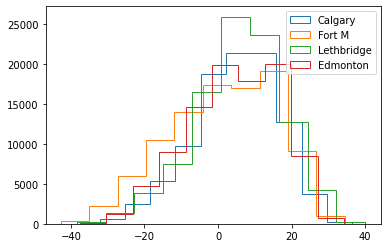

In [ ]:
bins = np.linspace(-60, 40, 60)

plt.hist(yyc_temp_raw["TEMP_CELSIUS"], histtype= 'step', label='Calgary')
plt.hist(fort_temp_raw["TEMP_CELSIUS"],  histtype= 'step', label='Fort M')
plt.hist(lethbridge_temp_raw["TEMP_CELSIUS"],  histtype= 'step', label='Lethbridge')
plt.hist(edmonton_temp_raw["TEMP_CELSIUS"], 
         histtype= 'step', label='Edmonton')
plt.legend(loc='upper right')
plt.show()

In [7]:
full_time = pd.DataFrame( pd.date_range(start='2010-01-01 07:00:00', end = '2021-01-05 07:00:00', freq='H'), 
                         columns = ["FULL_BEGIN_DATE_GMT"] )
print(full_time.shape)

# Function merge full time series
def merge_full_time(df, full_time):
    return full_time.merge(df, how ="left",
                           left_on =  "FULL_BEGIN_DATE_GMT",
                           right_on = "BEGIN_DATE_GMT")


(96529, 1)


In [8]:
yyc_temp_full = merge_full_time(yyc_temp_raw, full_time)
fort_temp_full = merge_full_time(fort_temp_raw, full_time)
lethbridge_temp_full =  merge_full_time(lethbridge_temp_raw, full_time)
edmonton_temp_full =  merge_full_time(edmonton_temp_raw, full_time)

print(yyc_temp_full.shape,fort_temp_full.shape, lethbridge_temp_full.shape, edmonton_temp_full.shape  )

(96529, 7) (96529, 7) (96529, 7) (96529, 7)


In [9]:
# Inspect to get missing time values

yyc_na = yyc_temp_full[ pd.isna(yyc_temp_full["TEMP_CELSIUS"])][["FULL_BEGIN_DATE_GMT"]]
fmm_na = fort_temp_full[ pd.isna(fort_temp_full["TEMP_CELSIUS"])][["FULL_BEGIN_DATE_GMT"]]
lb_na = lethbridge_temp_full[pd.isna(lethbridge_temp_full["TEMP_CELSIUS"])][["FULL_BEGIN_DATE_GMT"]]
edm_na = edmonton_temp_full[ pd.isna(edmonton_temp_full["TEMP_CELSIUS"])][["FULL_BEGIN_DATE_GMT"]]

for df in [yyc_na, fmm_na, lb_na, edm_na]:
    print( df.shape ) 

(44, 1)
(40, 1)
(233, 1)
(44, 1)


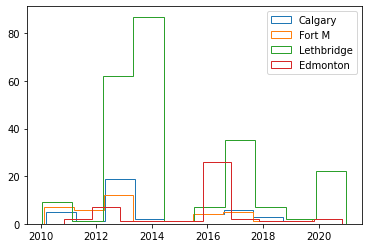

In [ ]:
bins = np.linspace(-60, 40, 50)
plt.hist(yyc_na["FULL_BEGIN_DATE_GMT"], 
         histtype= 'step', label='Calgary')
plt.hist(fmm_na["FULL_BEGIN_DATE_GMT"],  
         histtype= 'step', label='Fort M')
plt.hist(lb_na["FULL_BEGIN_DATE_GMT"],  
         histtype= 'step', label='Lethbridge')
plt.hist(edm_na["FULL_BEGIN_DATE_GMT"], 
         histtype= 'step', label='Edmonton')
plt.legend(loc='upper right')
plt.show()

In [10]:
def time_gap( next_gap, current):
    return (next_gap - current) / pd.Timedelta(hours=1)

def bfill_temperature(na_df,full_df):
    na_df["NEXT_GAP"] =  na_df["FULL_BEGIN_DATE_GMT"].shift(-1)
    na_df["PREV_GAP"] =  na_df["FULL_BEGIN_DATE_GMT"].shift(1)
    full_df["BFILL_TEMP_CELSIUS"] = pd.Series.copy(full_df["TEMP_CELSIUS"])

    # BFILL_TEMP_CELSIUS = pd.Series.copy(full_df[["FULL_BEGIN_DATE_GMT", "TEMP_CELSIUS"]])
    
    for index, row in na_df.iterrows():
        prev_gap = time_gap(row["FULL_BEGIN_DATE_GMT"], row["PREV_GAP"])
        next_gap= time_gap(row["NEXT_GAP"], row["FULL_BEGIN_DATE_GMT"])
        if prev_gap == 1.0 or next_gap == 1.0:
            last_day_temp = full_df[full_df["FULL_BEGIN_DATE_GMT"] == row["FULL_BEGIN_DATE_GMT"]-pd.Timedelta(days=1)]["BFILL_TEMP_CELSIUS"]
            full_df.at[index,"BFILL_TEMP_CELSIUS"] = last_day_temp
        else:
            last_hour_temp = full_df[full_df["FULL_BEGIN_DATE_GMT"] == row["FULL_BEGIN_DATE_GMT"]-pd.Timedelta(hours=1)]["BFILL_TEMP_CELSIUS"]
            full_df.at[index,"BFILL_TEMP_CELSIUS"] = last_hour_temp
    # full_df["BFILL_TEMP_CELSIUS"] = BFILL_TEMP_CELSIUS


bfill_temperature(yyc_na, yyc_temp_full)
bfill_temperature(fmm_na, fort_temp_full)
bfill_temperature(edm_na, edmonton_temp_full)
bfill_temperature(lb_na,lethbridge_temp_full)


In [11]:
# 2: Lethbridge
# 6: Calgary
# 11: Edmonton
# 16: Fort McMurray

def fill_aux_data(df, stream_name, region):
    df["BEGIN_DATE_GMT"] = df["FULL_BEGIN_DATE_GMT"]
    df["END_DATE_GMT"] = df["BEGIN_DATE_GMT"] + pd.Timedelta(hours = 1)
    df["Region"] = np.repeat(region, df.shape[0])
    final_df = df.fillna({'SOURCE_TIMEZONE': "MST", 'NRG_STREAM_NAME': stream_name})
    return final_df[df.columns.difference(["FULL_BEGIN_DATE_GMT","SOURCE_DATETIME","VERSION_BEGIN_LOCAL", "VERSION_END_LOCAL"])]

yyc_temp_final = fill_aux_data(yyc_temp_full, "EC - Calgary Temp", "6")
fort_temp_final = fill_aux_data(fort_temp_full, "EC - Fort McMurray Temp", "16")
lethbridge_temp_final = fill_aux_data(lethbridge_temp_full, "EC - Lethbridge Temp", "2")
edmonton_temp_final = fill_aux_data(edmonton_temp_full, "EC - Edmonton Temp", "11")


In [22]:
temps_final = pd.concat([yyc_temp_final, fort_temp_final, lethbridge_temp_final , edmonton_temp_final])
temps_final["Year"] = [begin_time.year for begin_time in temps_final["BEGIN_DATE_GMT"]]

In [23]:
temps_final.isna().sum()

BEGIN_DATE_GMT          0
BFILL_TEMP_CELSIUS      0
END_DATE_GMT            0
NRG_STREAM_NAME         0
Region                  0
SOURCE_TIMEZONE         0
TEMP_CELSIUS          361
Year                    0
dtype: int64

In [24]:
# with pd.ExcelWriter('cleaned data/Temps Data Back Filled.xlsx') as writer:  
#     yyc_temp_final.to_excel(writer, sheet_name='Calgary')
#     fort_temp_final.to_excel(writer, sheet_name='Fort McMurray')
#     lethbridge_temp_final.to_excel(writer, sheet_name='Lethbridge')
#     edmonton_temp_final.to_excel(writer, sheet_name='Edmonton')

# Filtering Population Data

In [25]:
# Reading in population data
pop_low_growth = pd.read_csv("original data/2020-2046-05-census-divisions-population-projections-low.csv",
                            dtype={'Year':int, 'Region': str, 'Sex': str, 'Age': str,'Pop': int })

pop_med_growth = pd.read_csv("original data/2020-2046-07-census-divisions-population-projections-medium.csv",
                             dtype={'Year':int, 'Region': str, 'Sex': str, 'Age': str,'Pop': int })

pop_high_growth = pd.read_csv("original data/2020-2046-09-census-divisions-population-projections-high.csv",
                             dtype={'Year':int, 'Region': str, 'Sex': str, 'Age': str,'Pop': int })

In [26]:
pop_full = pd.DataFrame(data = {"Year": pop_low_growth["Year"],
                               "Region": pop_low_growth["Region"],
                                "Sex": pop_low_growth["Sex"],
                                "Age": pop_low_growth["Age"],
                               "pop_low": pop_low_growth["Pop"],
                               "pop_medium": pop_med_growth["Pop"],
                                "pop_high": pop_high_growth["Pop"]
                               })

cd_divisions = ["2","6","11","16"]
# 2: Lethbridge
# 6: Calgary
# 11: Edmonton
# 16: Fort McMurray

def base_filter(df):
    period = (df["Year"] >= 2010)
    in_4_metros = df["Region"].apply(lambda x: x in cd_divisions)
    conditions = period & in_4_metros & (df["Sex"] == "3") & (df["Age"] =="Total")
              
    return df[conditions][df.columns.difference(["Sex","Age"])]
def gen_pop_pct(pop_df, pop_col ):
    pop_by_year =  pop_df.groupby(['Year','Region']).agg({pop_col: 'sum'})
    pop_pct = pop_by_year.groupby(level=0).apply(lambda x: x / float(x.sum()))
    return pop_pct.reset_index()

pop_metros =  base_filter(pop_full)

pop_metros_sorted = pop_metros.sort_values(["Year", "Region"])

for pop_col in ["pop_high","pop_low","pop_medium"]:
    pop_pct = gen_pop_pct(pop_metros_sorted, pop_col).sort_values(["Year", "Region"])
    pop_metros_sorted["pct_"+pop_col]  = [pct for pct in pd.Series.copy(pop_pct[pop_col])]

# Combining temperature and population

In [18]:
# pop_metros_sorted.to_excel("cleaned data/Population 2010-2046.xls")

In [27]:
# Combining temperature and population

pop_cols = ["pop_high","pop_low","pop_medium"]

def merge_population(temp_df, pop_df):
    return temp_df.merge(pop_metros, on = ['Year','Region'], how = 'left')

def gen_weighted_temp(temp_df, temp_col, pop_df, pop_col):
    pop_pct = gen_pop_pct(pop_df, pop_col)
    temp_df["Year"] =  [begin_time.year for begin_time in temp_df["BEGIN_DATE_GMT"]]
    weighted_temp = temp_df.merge(pop_pct, on = ['Year','Region'], how = 'left')
    weighted_temp[temp_col + "_weighted_"+pop_col] = weighted_temp[temp_col] * weighted_temp["pct_"+pop_col]
    return weighted_temp

# Weight temperature by population
weighted_temp = temps_final.merge(pop_metros_sorted, on = ['Year','Region'], how = 'left')
temp_col = "BFILL_TEMP_CELSIUS"

for pop_col in ["pop_high","pop_low","pop_medium"]:
    weighted_temp[temp_col.replace("_TEMP_CELSIUS","") + "_weighted_" + pop_col] = weighted_temp[temp_col] * weighted_temp["pct_"+pop_col]
weighted_temp.sort_values(["BEGIN_DATE_GMT","Region"], inplace = True)
weighted_temp.rename(str.upper, axis='columns', inplace = True)

# Replacing names for convenience
weighted_temp.replace({'EC - Calgary Temp' : 'CALGARY', 
                            "EC - Edmonton Temp" : 'EDMONTON',
                            "EC - Fort McMurray Temp" :"FORTMM",
                            "EC - Lethbridge Temp": "LETHBRG"}, inplace = True)

weighted_temp.reindex().to_csv("cleaned data/Long Format_Weighted Temp 2010-2021.csv")

In [29]:
weighted_temp_wide = weighted_temp.drop(columns = ["YEAR", "REGION", "SOURCE_TIMEZONE"]).reindex()

weighted_temp_wide = weighted_temp_wide.pivot_table(index ='BEGIN_DATE_GMT', columns = "NRG_STREAM_NAME",
                                                    margins= False)
weighted_temp_wide.columns = weighted_temp_wide.columns.map('|'.join).str.strip('|')


In [30]:
weighted_temp_wide.to_csv("cleaned data/Wide Format_Weighted Temp 2010-2021.csv")

In [20]:
temp_data =pd.read_csv("cleaned data/Wide Format_Weighted Temp 2010-2021.csv")
temp_data.head()

,BEGIN_DATE_GMT,BFILL_TEMP_CELSIUS|CALGARY,BFILL_TEMP_CELSIUS|EDMONTON,BFILL_TEMP_CELSIUS|FORTMM,BFILL_TEMP_CELSIUS|LETHBRG,BFILL_WEIGHTED_POP_HIGH|CALGARY,BFILL_WEIGHTED_POP_HIGH|EDMONTON,BFILL_WEIGHTED_POP_HIGH|FORTMM,BFILL_WEIGHTED_POP_HIGH|LETHBRG,BFILL_WEIGHTED_POP_LOW|CALGARY,...,POP_LOW|FORTMM,POP_LOW|LETHBRG,POP_MEDIUM|CALGARY,POP_MEDIUM|EDMONTON,POP_MEDIUM|FORTMM,POP_MEDIUM|LETHBRG,TEMP_CELSIUS|CALGARY,TEMP_CELSIUS|EDMONTON,TEMP_CELSIUS|FORTMM,TEMP_CELSIUS|LETHBRG
0,2010-01-01 07:00:00,-21.7,-24.3,-30.5,-19.9,-10.392206,-10.677110,-0.740259,-1.143025,-10.392206,...,67824,160510,1338281,1227854,67824,160510,-21.7,-24.3,-30.5,-19.9
1,2010-01-01 08:00:00,-21.3,-24.0,-30.7,-19.1,-10.200645,-10.545294,-0.745114,-1.097075,-10.200645,...,67824,160510,1338281,1227854,67824,160510,-21.3,-24.0,-30.7,-19.1
2,2010-01-01 09:00:00,-21.0,-23.9,-30.8,-18.0,-10.056974,-10.501355,-0.747541,-1.033892,-10.056974,...,67824,160510,1338281,1227854,67824,160510,-21.0,-23.9,-30.8,-18.0
3,2010-01-01 10:00:00,-20.4,-23.6,-30.7,-17.3,-9.769632,-10.369539,-0.745114,-0.993685,-9.769632,...,67824,160510,1338281,1227854,67824,160510,-20.4,-23.6,-30.7,-17.3
4,2010-01-01 11:00:00,-20.4,-23.0,-30.2,-16.0,-9.769632,-10.105906,-0.732978,-0.919015,-9.769632,...,67824,160510,1338281,1227854,67824,160510,-20.4,-23.0,-30.2,-16.0


In [15]:
temp_data["Avg temp"] = ( temp_data['BFILL_TEMP_CELSIUS|CALGARY'] +  temp_data['BFILL_TEMP_CELSIUS|EDMONTON'] + temp_data['BFILL_TEMP_CELSIUS|FORTMM'] + temp_data['BFILL_TEMP_CELSIUS|LETHBRG']  ) / 4

temp_data["Weighted Avg Temp"] = temp_data['BFILL_WEIGHTED_POP_MEDIUM|CALGARY'] + temp_data['BFILL_WEIGHTED_POP_MEDIUM|EDMONTON'] + temp_data['BFILL_WEIGHTED_POP_MEDIUM|FORTMM'] + temp_data['BFILL_WEIGHTED_POP_MEDIUM|LETHBRG']

In [16]:
temp_data = temp_data[["BEGIN_DATE_GMT","Avg temp", "Weighted Avg Temp"]]

In [17]:
temp_data.head()

,BEGIN_DATE_GMT,Avg temp,Weighted Avg Temp
0,2010-01-01 07:00:00,-24.100,-22.952601
1,2010-01-01 08:00:00,-23.775,-22.588126
2,2010-01-01 09:00:00,-23.425,-22.339761
3,2010-01-01 10:00:00,-23.000,-21.877969
4,2010-01-01 11:00:00,-22.400,-21.527531


In [18]:
temp_data.to_csv("cleaned data/Medium_Weighted Temp 2010-2021.csv")